# SNODAS Wrapper

In [1]:
%matplotlib inline
import re
import os
import math
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from SNODAS import SNODAS
from MountainHub import MountainHub as mh

## Downloading Data from SNODAS
Data can be fetched from SNODAS using the `snodas_ds(date)` function. It can then be saved using the appropriate function e.g.`save_netcdf(dataset, path)` or `save_tiff(dataset, path)`

In [6]:
# Fetch data from SNODAS
start_date = datetime(2017,8,1)
for date in (start_date + timedelta(n) for n in range(1)):
    ds = SNODAS.snodas_ds(date)
    SNODAS.save_netcdf(ds, date.strftime('SNODAS/out/SNODAS_%Y%m%d.nc'))

## Merging files into single NetCDF files
Merging together NetCDF files for different dates can be accomplished by reading those files into xarray, and then writing the resulting dataset out to a new NetCDF file. It is important to set the proper coordinates along the time axis of the dataset before writing, in order to record the date of each individual layer. 

In [9]:
# Get list of valid files
pattern = re.compile("^SNODAS_\d{8}.nc$")
# There's something wrong with SNODAS-20170913 - only use files after this for now
files = sorted([os.path.join("SNODAS/out",f) for f in os.listdir("SNODAS/out") if pattern.match(f)])[23:]
# Extract dates from files
dates = [SNODAS.dateFromFile(f) for f in files]

ds = xr.open_mfdataset(files, concat_dim='time', autoclose=True)
ds.coords['time'] = dates

ds.to_netcdf('SNODAS/out/SNODAS_2017_2018_2.nc')

SNODAS/out/SNODAS_20170913.nc


## Loading Merged Data in XArray
The merged dataset can then be reimported to xarray with the following function. The merging process is important, as it allows xarray to search the dataset much faster, opening up the possibility of API queries.

In [7]:
ds = xr.open_dataset('SNODAS/out/SNODAS_2017_2018_2.nc')

## Selecting snow depth across region
Data can be selected in a particular region by using the `sel` and `isel` functions in conjunction with `slice`, as shown below.

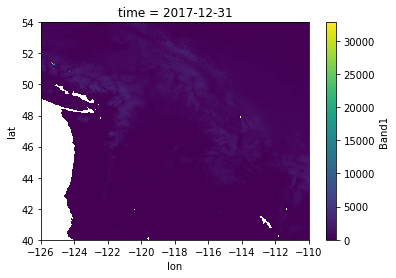

In [8]:
ds.Band1.sel(time = '2017-12-31', lat = slice(40, 54), lon = slice(-126, -110)).plot()

## Selecting time series at location
A time series can be constructed as follows. It is important that the method parameter is set to `'nearest'` in order to recieve results.

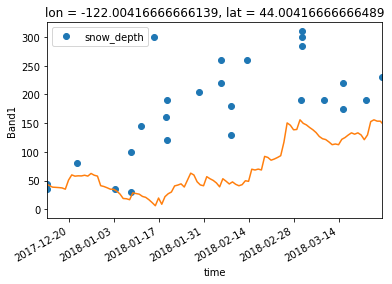

In [5]:
lat = 44.0018751
lon = -122.004

region = {
    'ymax' : 44.25,
    'ymin' : 43.75,
    'xmax': -121.65,
    'xmin': -122.5,
}

obs = mh.snow_data(limit=1000, start=datetime(2017,8,1), end=datetime(2018,3,28), box=region)
obs = mh.merge_el_data(obs)

plot = obs.plot(x='date', y='snow_depth', style='o')
snodas_series = ds.Band1.sel(lat=lat, lon=-122, method='nearest') / 10
snodas_series.plot(ax=plot)


## Selecting point data at time and location
Data can be easily selected for a particular location and date. In the example below, snow depth is retrieved for January 3, 2018 near 44° N, 121.65° W.

In [9]:
ds.sel(time = '2018-1-3', lon = -121.65, lat = 44, method='nearest').Band1.item()

254.0

## Plotting Data Against SNODAS

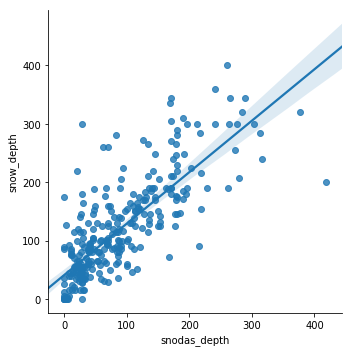

In [16]:
# Restrict points to the continental US
region = {
    'ymax' : 50,
    'ymin' : 25,
    'xmax': -65,
    'xmin': -125,
}

obs = mh.snow_data(limit=1000, start=datetime(2017,9,14), end=datetime(2018,3,28), box=region)
def snodas_depth(ts, lon, lat):
    height = ds.Band1.sel(time = ts.strftime('%Y-%m-%d'), lon=lon, lat=lat, method='nearest').item()
    if not np.isnan(height):
        height /= 10
    return height

obs['snodas_depth'] = obs.apply(lambda x: snodas_depth(x['date'], x['long'], x['lat']), axis=1)
sns.lmplot(x='snodas_depth',y='snow_depth',data=obs, fit_reg=True, robust=True) 